# **Plot Probing Model Accuracy**

In [28]:
import os
import matplotlib.pyplot as plt
import json
from pylab import rcParams
import seaborn as sns
import pandas as pd
import zipfile
import wandb

### **1. Extract model's checkpoints and results**

In [5]:
PROJ_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

In [12]:
def unzip_strip_prefix(zip_path, extract_to, prefix_to_strip):
    """
    Estrae i file da uno zip rimuovendo un prefisso dal path interno dei file.
    
    :param zip_path: Percorso allo zip.
    :param extract_to: Cartella dove estrarre.
    :param prefix_to_strip: Parte iniziale del percorso da rimuovere (es. tutto prima di 'checkpoints_save_latest').
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for member in zip_ref.namelist():
            # Salta le directory
            if member.endswith('/'):
                continue

            # Se contiene il prefisso da cui vogliamo partire
            if prefix_to_strip in member:
                relative_path = member.split(prefix_to_strip, 1)[1].lstrip("/")
                target_path = os.path.join(extract_to, relative_path)

                # Crea le directory di destinazione se necessario
                os.makedirs(os.path.dirname(target_path), exist_ok=True)

                # Estrai il file con percorso corretto
                with zip_ref.open(member) as source, open(target_path, "wb") as target:
                    target.write(source.read())


In [14]:
CHECKPOINT_ZIP = os.path.join(PROJ_DIR, "Meta-Llama-3-8B_checkpoints.zip")
PREFIX_TO_STRIP = "checkpoints_save_latest"
PATH_TO_SAVE = os.path.join(PROJ_DIR, PREFIX_TO_STRIP)


unzip_strip_prefix(CHECKPOINT_ZIP, PATH_TO_SAVE, PREFIX_TO_STRIP)

In [19]:
RESULTS_ZIP = os.path.join(PROJ_DIR, "Meta-Llama-3-8B_results.zip")
PREFIX_TO_STRIP = "results_save_latest"
PATH_TO_SAVE = os.path.join(PROJ_DIR, PREFIX_TO_STRIP)


unzip_strip_prefix(RESULTS_ZIP, PATH_TO_SAVE, PREFIX_TO_STRIP)

### **2. Plot accuracy over layers**

In [24]:
def get_records(model_path, data_name, l1_factor, k_shot, tag=""):
    model_name = os.path.basename(model_path)
    if "gemma" in model_name:
        layer_num = 42
    else:
        layer_num = 32
    records = []
    for analyse_activation in ["hidden", "mlp", "attn"]:
        #results_dir = os.path.join(PROJ_DIR, "results", model_name, data_name)
        latest_results_dir = os.path.join(PROJ_DIR, "results_save_latest", model_name, data_name)
        
        if k_shot == 0:
            #result_dir = os.path.join(results_dir, f"prob_conflict_zero_shot_act{tag}", analyse_activation)
            latest_results_dir = os.path.join(latest_results_dir, f"prob_conflict_zero_shot_act{tag}", analyse_activation)
        else:
            #result_dir = os.path.join(results_dir, f"prob_conflict{tag}", analyse_activation)
            latest_results_dir = os.path.join(latest_results_dir, f"prob_conflict{tag}", analyse_activation)
        
        for layer_idx in range(layer_num):
            #logs_path = os.path.join(latest_results_dir, f"layer{layer_idx}_acc_auc_L1factor{l1_factor}.json")
            #logs = json.load(open(logs_path, "r"))

            latest_logs_path = os.path.join(latest_results_dir, f"layer{layer_idx}_acc_auc_L1factor{l1_factor}.json")
            if os.path.exists(latest_logs_path):
                latest_logs = json.load(open(latest_logs_path, "r"))

                for idx in range(len(latest_logs["all_ACC"])):
                    cur_acc = latest_logs["all_ACC"][idx]
                    records.append({"activation": analyse_activation, "layer": layer_idx, "acc": cur_acc,
                                    "auc": latest_logs["all_AUC"][idx], "auprc": latest_logs["all_AUPRC"][idx], })
            # else:
            #     for idx in range(len(logs["all_ACC"])):
            #         records.append({"activation": analyse_activation, "layer": layer_idx, "acc": logs["all_ACC"][idx],
            #                         "auc": logs["all_AUC"][idx], "auprc": logs["all_AUPRC"][idx], })
    return records

In [25]:
def plot_model_accuracy(model_path="meta-llama/Meta-Llama-3-8B",
                                data_name="nqswap",
                                k_shot=4,
                                l1_factor=None,
                                tag=""):
    model_name = os.path.basename(model_path)

    records = get_records(model_path, data_name, l1_factor, k_shot, tag)
    print(f"Total records: {len(records)}")
    records = pd.DataFrame.from_records(records)
    print(records.head())
    palette = {"hidden": "red", "mlp": "blue", "attn": "green"}

    image_save_dir = os.path.join(PROJ_DIR, "images", "KC-detection-probing")
    os.makedirs(image_save_dir, exist_ok=True)

    rcParams['axes.labelsize'] = 21
    rcParams['xtick.labelsize'] = 15
    rcParams['ytick.labelsize'] = 15
    rcParams['legend.fontsize'] = 22
    rcParams['legend.title_fontsize'] = 20
    rcParams.update({
        'font.family': 'serif',
        'text.usetex': False,
        'mathtext.default': 'regular',
        'font.weight': 'bold',
    })

    plt.figure(figsize=(20, 12), dpi=150)
    sns.lineplot(data=records, x="layer", y="acc", hue="activation", palette=palette)
    # plt.title(f"Probing model for conflict classification. Accuracy\n{model_name} {data_name}")
    plt.ylabel("Accuracy")
    plt.xlabel("Layer")
    plt.grid(True)
    plt.savefig(os.path.join(image_save_dir, f"{model_name} {data_name} Accuracy.pdf"), format='pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(20, 12), dpi=150)
    sns.lineplot(data=records, x="layer", y="auc", hue="activation", palette=palette)
    plt.ylabel("AUROC")
    plt.xlabel("Layer")
    plt.grid(True)
    plt.legend(loc="lower right", title="activation")
    plt.savefig(os.path.join(image_save_dir, f"{model_name} {data_name} AUROC.pdf"), format='pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(20, 12), dpi=150)
    sns.lineplot(data=records, x="layer", y="auprc", hue="activation", palette=palette)
    plt.ylabel("AUPRC")
    plt.xlabel("Layer")
    plt.grid(True)
    plt.savefig(os.path.join(image_save_dir, f"{model_name} {data_name} AUPRC.pdf"), format='pdf', bbox_inches='tight')
    plt.show()


In [26]:
MODEL_NAME = "meta-llama/Meta-Llama-3-8B"
DATASET = "nqswap"
LAYERS = list(range(10, 25))
ACTIVATION_TYPES = ["hidden", "mlp", "attn"]

Total records: 900
  activation  layer       acc       auc     auprc
0     hidden     10  0.539604  0.620329  0.825975
1     hidden     10  0.586634  0.620066  0.825162
2     hidden     10  0.514851  0.623355  0.828865
3     hidden     10  0.636139  0.617401  0.823929
4     hidden     10  0.527228  0.618783  0.825510


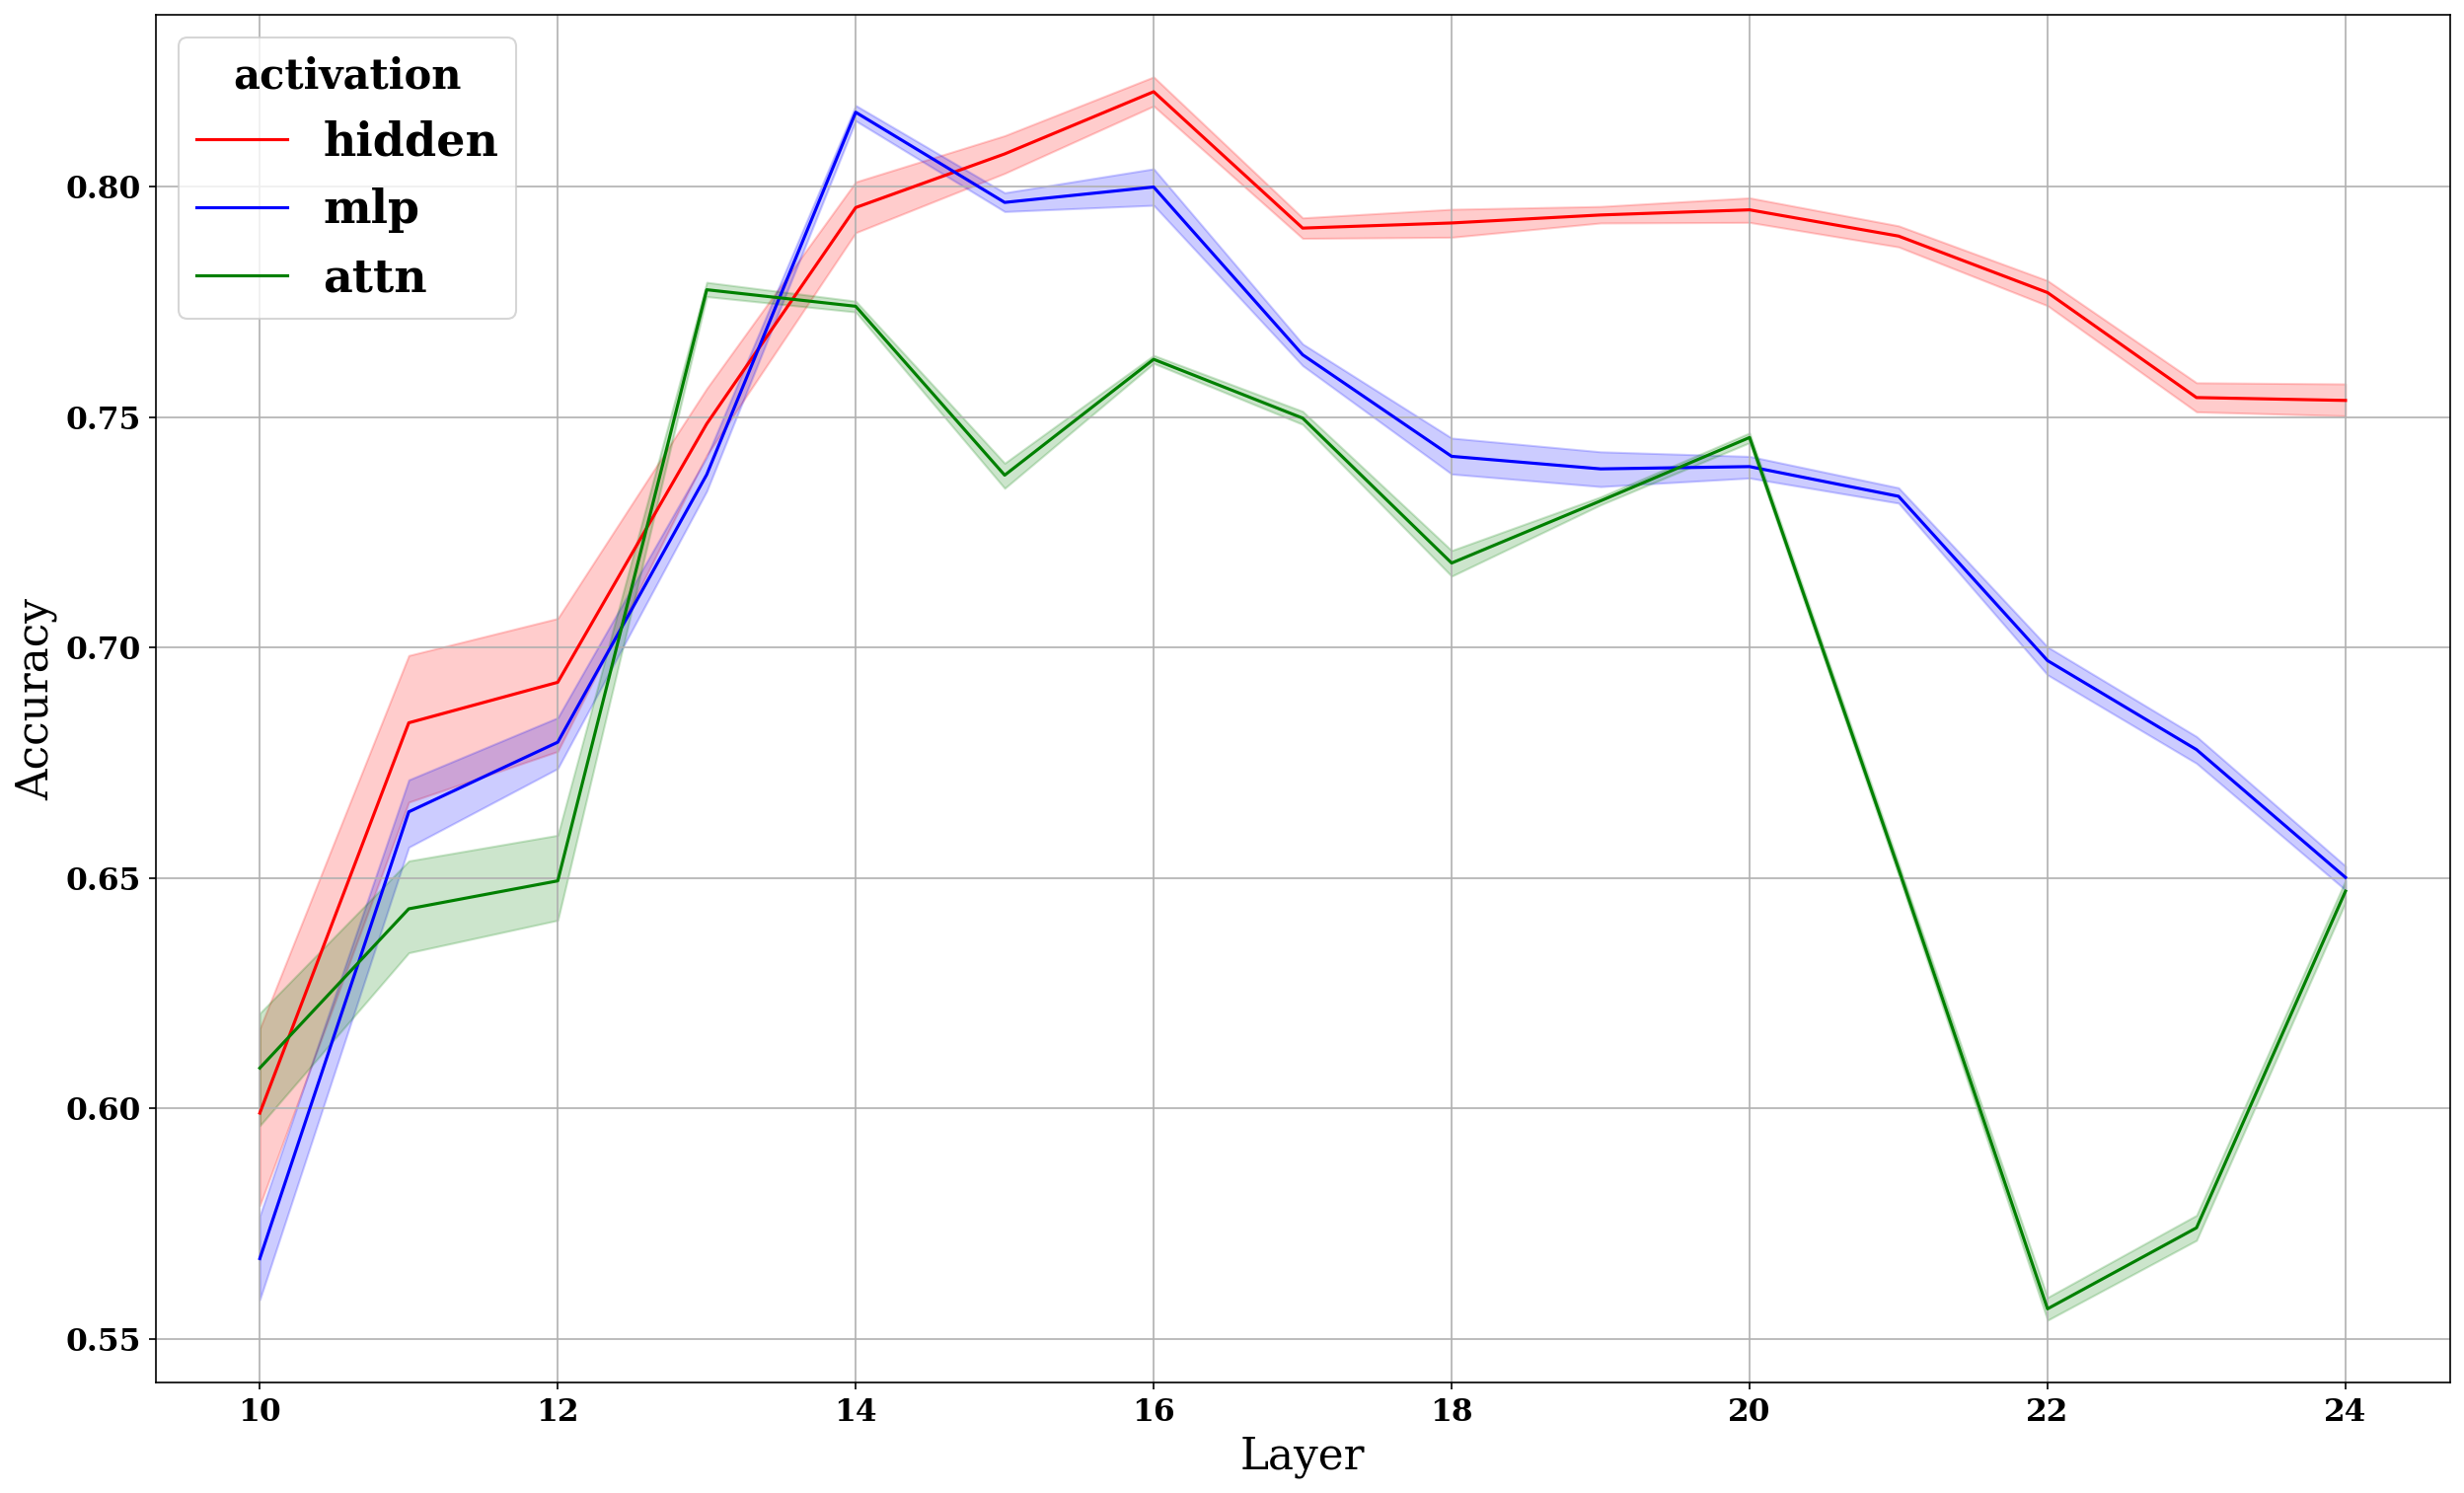

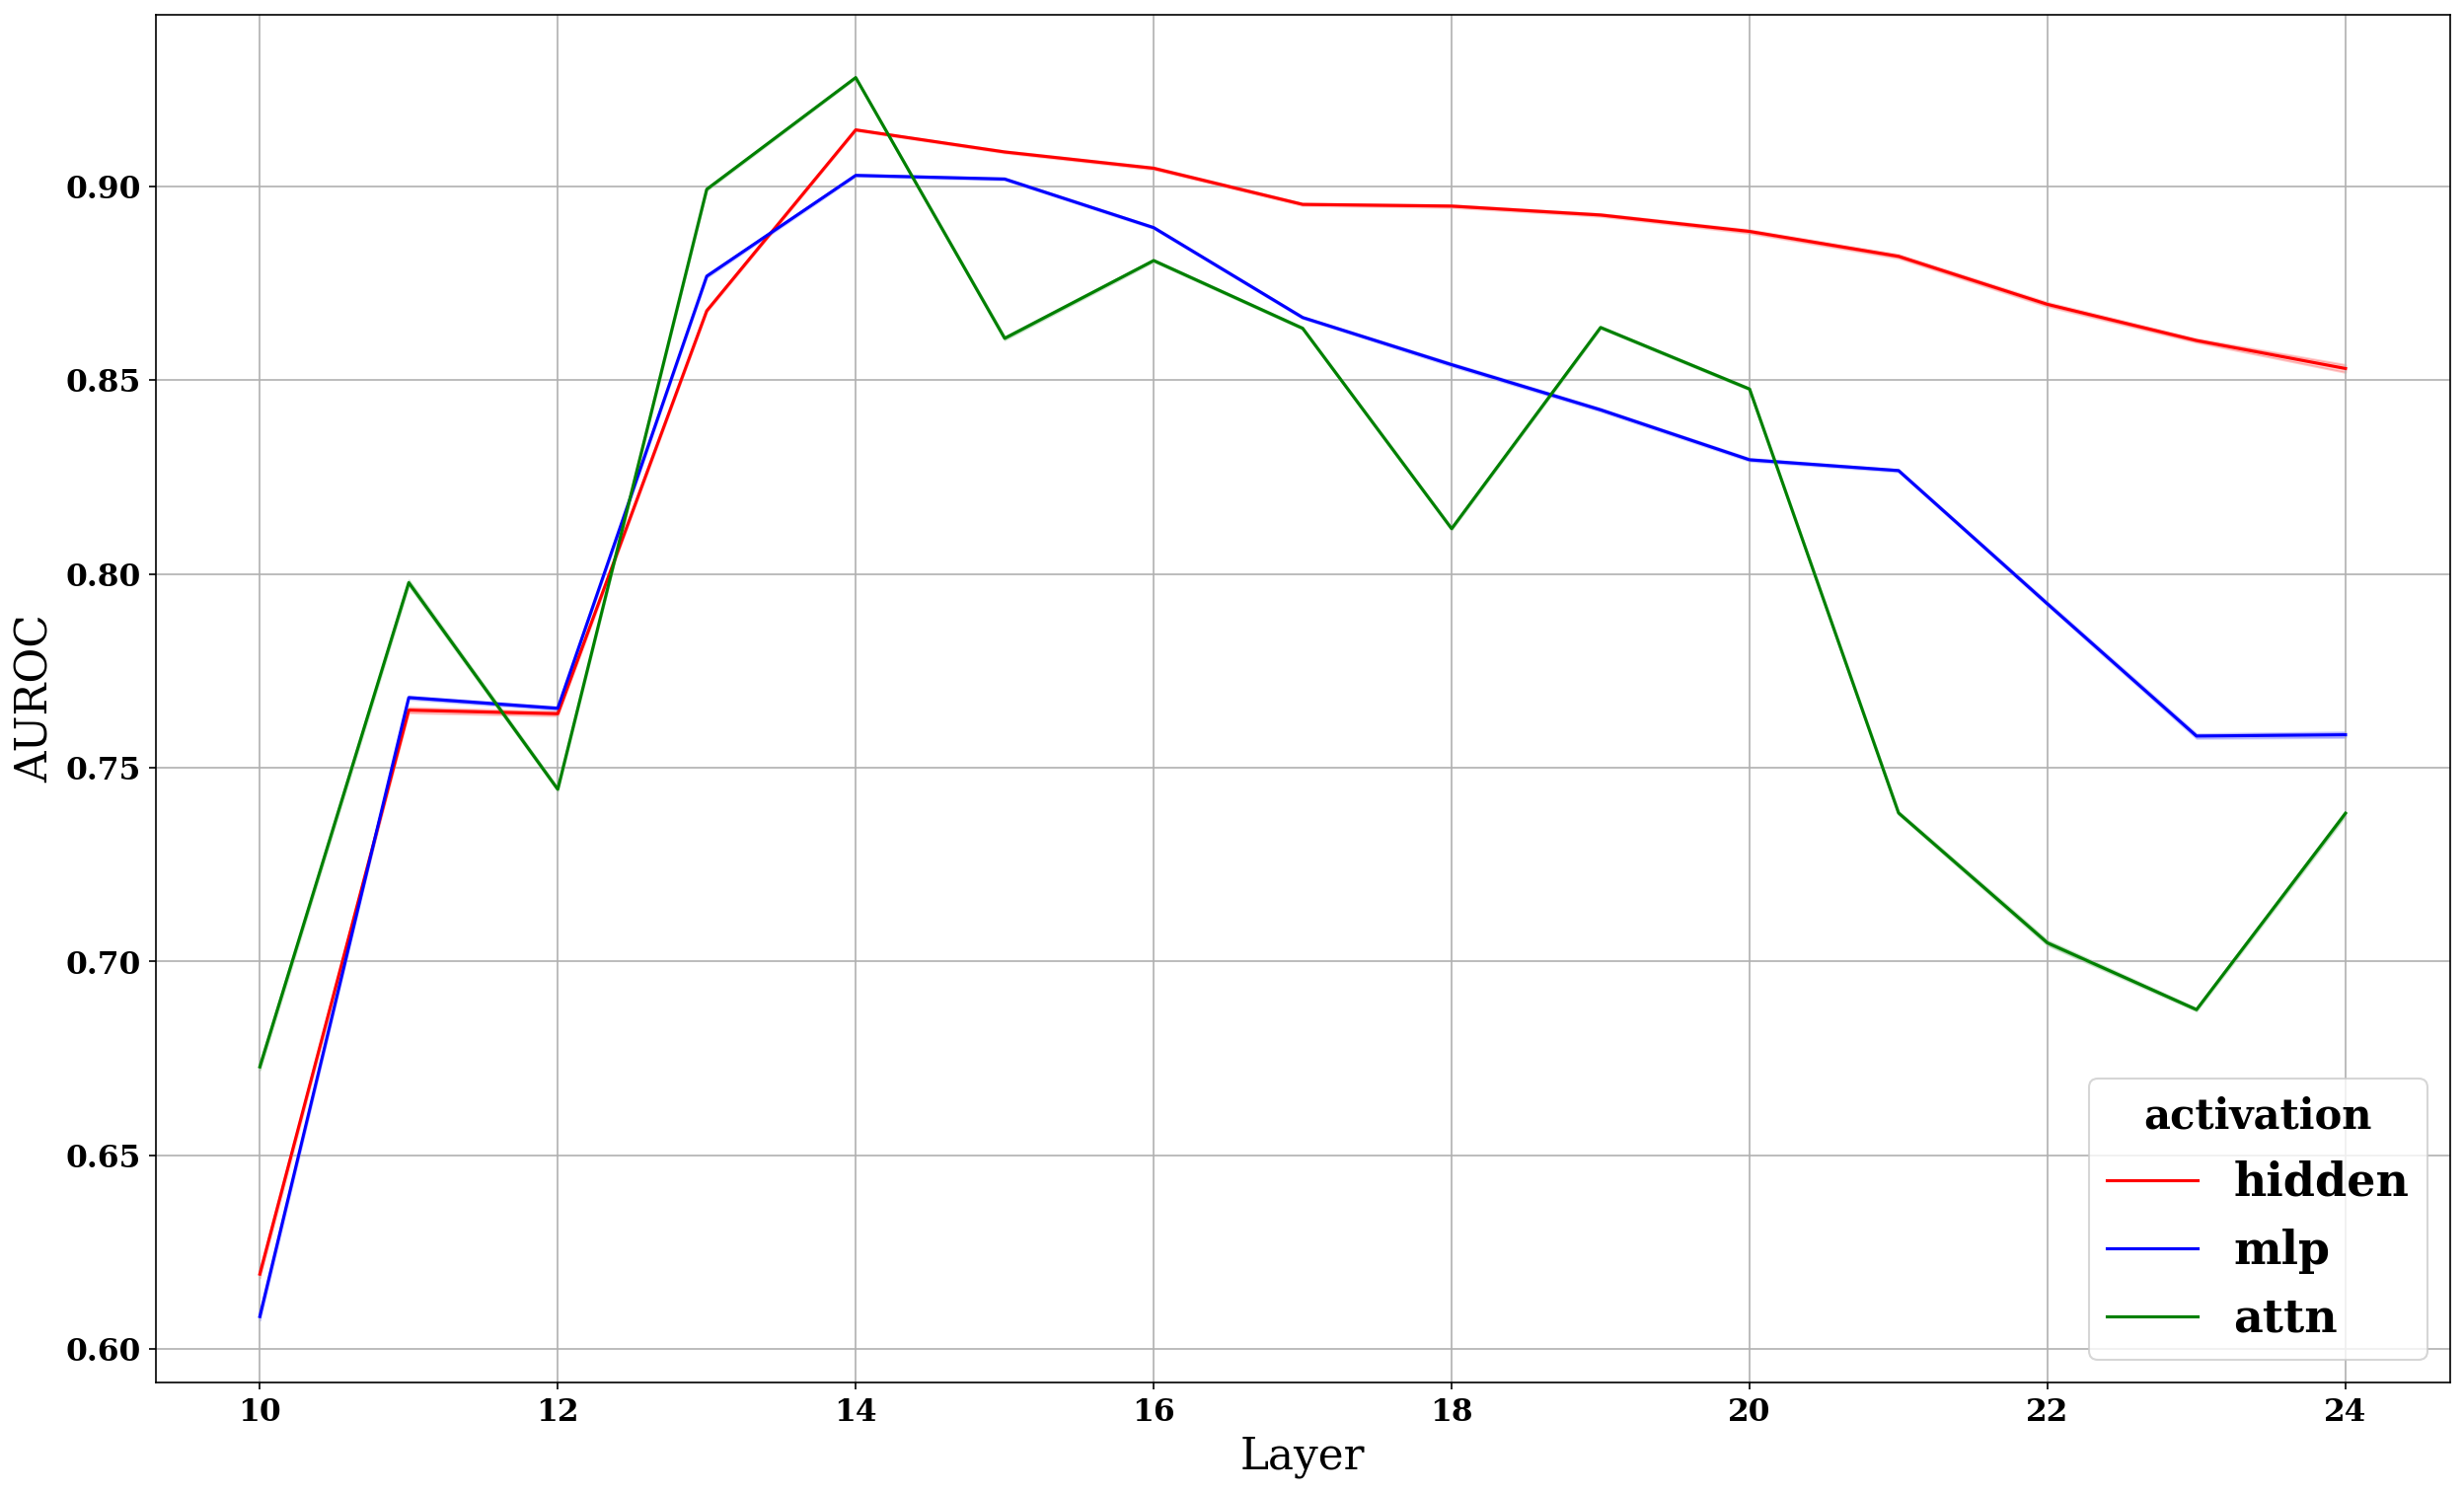

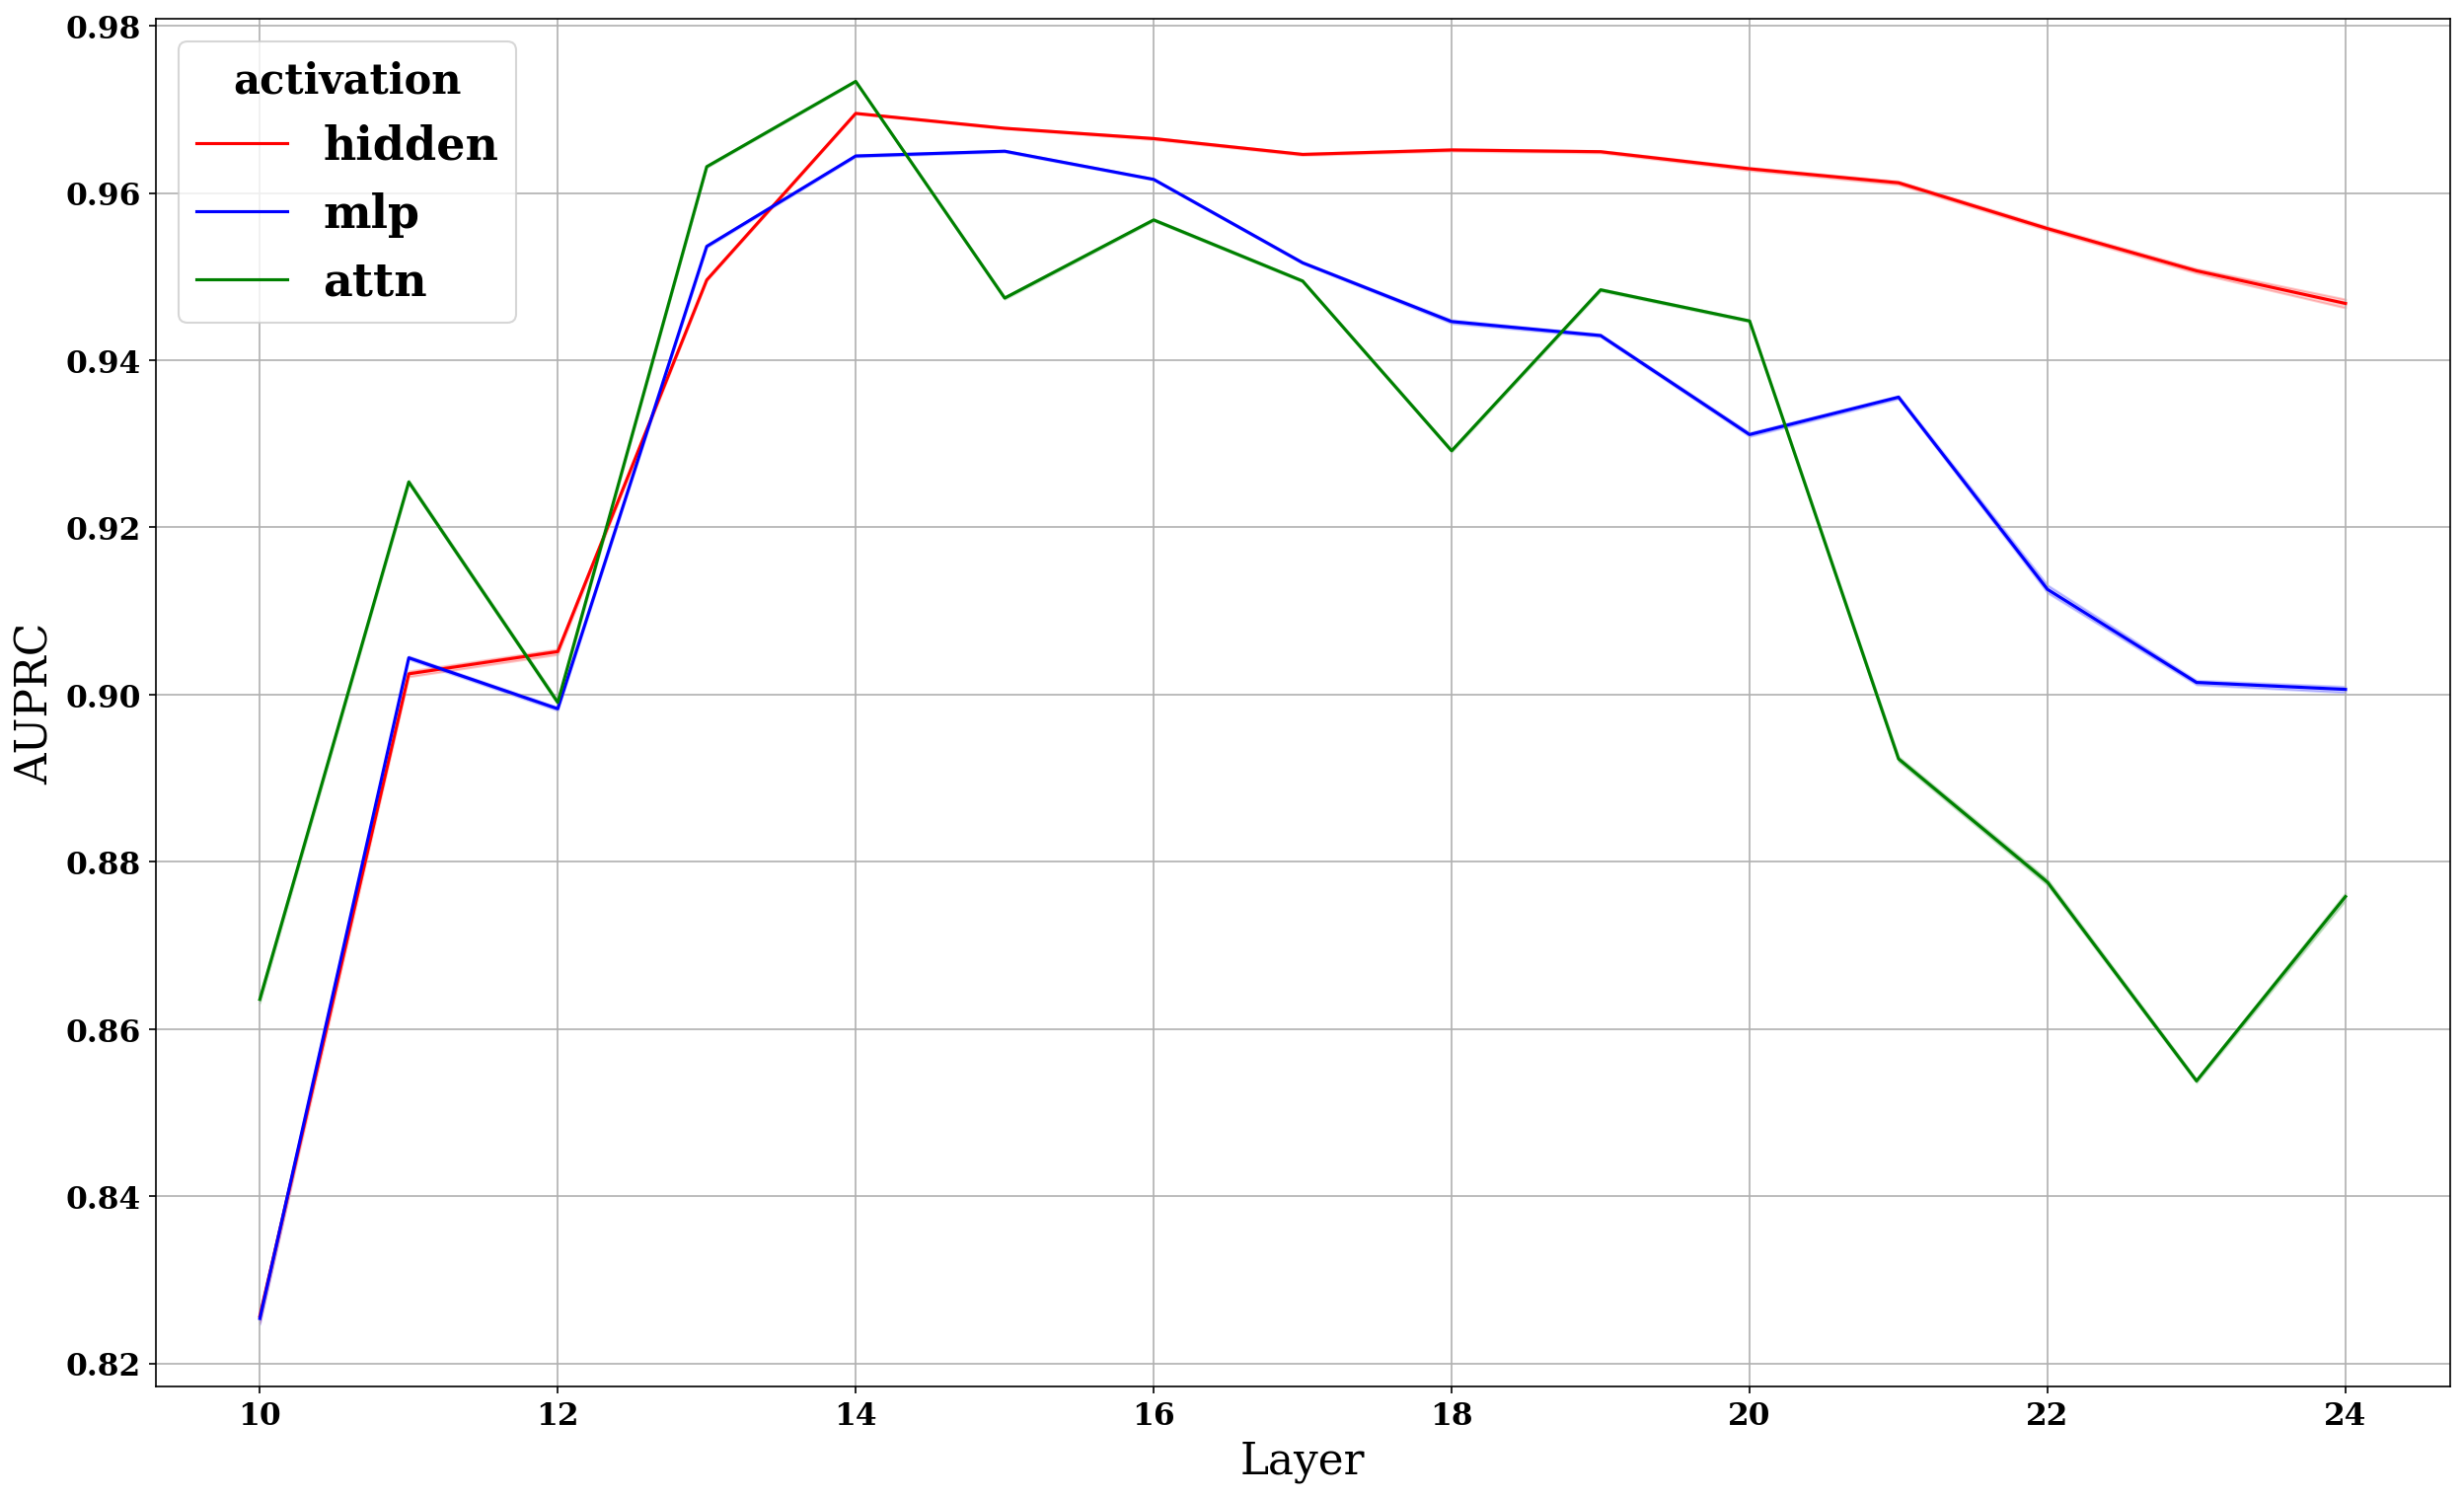

In [27]:
plot_model_accuracy(model_path=MODEL_NAME, data_name=DATASET, l1_factor=3)

### **3. Save best model(s) on WandB**

In [29]:
WANDB_ENTITY = "llaraspata-cilab"
WANDB_PROJECT = "Hallucination"
WANDB_RUN_NAME = "knowledge_conflict_detection_probing"
DATASET_NAME = "nqswap"
LEARNING_RATE = 0.002
EPOCHS = 20
TRAIN_TIMES = 20

In [30]:
MODEL_NAME = "meta-llama/Meta-Llama-3-8B"
LAYERS = list(range(10, 25))
ACTIVATION_TYPES = ["hidden", "mlp", "attn"]

ACTIVATION_TYPE = "hidden"
CHECKPOINT_PATH = os.path.join(PROJ_DIR, "checkpoints_save_latest", MODEL_NAME.split("/")[-1], DATASET_NAME, "prob_conflict", ACTIVATION_TYPE)
BEST_LAYERS = list(range(14, 17)) # upper bound excluded

In [31]:
run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    id=WANDB_RUN_NAME,
    name=WANDB_RUN_NAME,
    config={
        "learning_rate": LEARNING_RATE,
        "architecture": MODEL_NAME,
        "dataset": DATASET_NAME,
        "train_times": TRAIN_TIMES,
        "epochs": EPOCHS,
        "k-shots": 4,
        "l1_factor": 3,
        "layers": LAYERS,
        "activation_types": ACTIVATION_TYPES,
    },
)

wandb: Currently logged in as: llaraspata (llaraspata-cilab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [32]:
for layer in BEST_LAYERS:
    checkpoint_path = os.path.join(CHECKPOINT_PATH, f"prob_model_list_{layer}_L1factor3.pt")

    if os.path.exists(checkpoint_path):
        probing_model_name = f"kc_{ACTIVATION_TYPE}_layer{layer}"
        artifact = wandb.Artifact(probing_model_name, type='model')
        artifact.add_file(checkpoint_path)
        run.log_artifact(artifact)
        print(f"Saved checkpoint for layer {layer} at {checkpoint_path}")
    else:
        print(f"Checkpoint for layer {layer} does not exist at {checkpoint_path}")

run.finish()

Saved checkpoint for layer 14 at /home/lucrezia/SAE-based-representation-engineering/checkpoints_save_latest/Meta-Llama-3-8B/nqswap/prob_conflict/hidden/prob_model_list_14_L1factor3.pt
Saved checkpoint for layer 15 at /home/lucrezia/SAE-based-representation-engineering/checkpoints_save_latest/Meta-Llama-3-8B/nqswap/prob_conflict/hidden/prob_model_list_15_L1factor3.pt
Saved checkpoint for layer 15 at /home/lucrezia/SAE-based-representation-engineering/checkpoints_save_latest/Meta-Llama-3-8B/nqswap/prob_conflict/hidden/prob_model_list_15_L1factor3.pt


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Saved checkpoint for layer 16 at /home/lucrezia/SAE-based-representation-engineering/checkpoints_save_latest/Meta-Llama-3-8B/nqswap/prob_conflict/hidden/prob_model_list_16_L1factor3.pt
